In [1]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from evaluation import *

In [2]:
cwd = os.getcwd()

### Muraro example ###

In [5]:
# load labels and embeddings
X_train = np.load(f"{cwd}/data/muraro_log_pca.npy")
y_train = np.load(f"{cwd}/data/muraro_labels.npy")
pcaM = np.load(f"{cwd}/embeddings/Muraro/Muraro_pca.npy")
umapM = np.load(f"{cwd}/embeddings/Muraro/Muraro_umap.npy")

# create PCA reducer
reducer = PCA(n_components=2, random_state=42)

In [7]:
alpha_list = np.linspace(0,1,101) # 0 to 1 inclusive, step = 0.01
muraro_accs = [] # list of maps (created in loop)

# get and plot embeddings
for alpha in alpha_list:
    # scale UMAP, PCA embeddings by alpha, (1-alpha) respectively
    umapM_sc = umapM * (alpha) # sc for scaled
    pcaM_sc = pcaM * (1-alpha)
    # concatenate
    concat_emb = np.concatenate((pcaM_sc,umapM_sc), axis=1)
    # reduce to 2 dimensions
    embedding = reducer.fit_transform(concat_emb)
    embedding = embedding / LA.norm(embedding) # normalize scale to 1

    # dictionary to store results of this particular alpha val
    acc = dict()
    # store alpha
    acc['alpha'] = alpha

    # compute RT
    rt_acc = np.zeros(5,)
    for i in range(5):
        rt_acc[i] = random_triplet_eval(X_train, embedding, y_train) #X_train, embedding, labels
    acc['rt'] = np.mean(rt_acc)

    # compute CT
    ct_acc = centroid_triplet_eval(X_train, embedding, y_train) #X_train, embedding, labels
    acc['ct'] = np.mean(ct_acc)

    # compute kNN
    knn_acc = knn_eval(embedding, y_train, n_neighbors = 5)
    acc['knn'] = knn_acc

    muraro_accs.append(acc)
    
muraro_df = pd.DataFrame(muraro_accs)

muraro_df

,alpha,rt,ct,knn
0,0.00,0.757739,0.796825,0.655127
1,0.01,0.756950,0.796825,0.655127
2,0.02,0.755653,0.796825,0.654689
3,0.03,0.757213,0.796825,0.653812
4,0.04,0.757020,0.796825,0.655127
...,...,...,...,...
96,0.96,0.636494,0.607937,0.960999
97,0.97,0.637318,0.607937,0.961437
98,0.98,0.637301,0.607937,0.961437
99,0.99,0.637493,0.607937,0.960999


In [9]:
muraro_df.to_csv(f"{cwd}/muraro_df.csv", index=False)

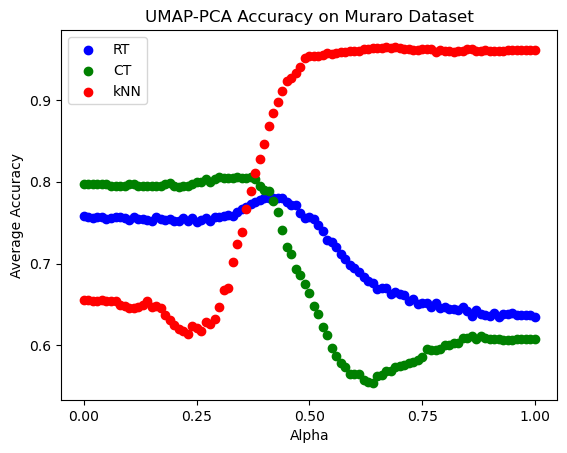

In [11]:
# create plot
metrics = ['rt', 'ct', 'knn']
color_map = {'rt': 'blue', 'ct':'green', 'knn':'red'}
label_map = {'rt': 'RT', 'ct':'CT', 'knn': 'kNN'}

plt.figure()
for metric in metrics:
    plt.scatter(alpha_list, muraro_df[metric], color=color_map[metric],label= label_map[metric])
plt.xticks(np.linspace(0,1,5))
plt.title("UMAP-PCA Accuracy on Muraro Dataset")
plt.xlabel('Alpha')  
plt.ylabel('Average Accuracy')
plt.legend()
plt.show()